# Lab 2 forward-pass and back-propagation

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
    """Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    return 1 / (1 + np.exp(-x))


def der_sigmoid(y):
    """First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    return y * (1 - y)


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, (x > y).astype(np.int64).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_chessboard(n=100):
        """Data generation (Chessboard)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64).reshape(
            (-1, 1)
        )

    @staticmethod
    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR" or mode == "Chessboard"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor, "Chessboard": GenData._gen_chessboard}[mode]

        return data_gen_func(n)


class SimpleNet:

    def linear(self, in_ch, out_ch):
        # weight_Mat = np.array([[np.random.uniform(-1, 1)]*in_ch for _ in range(out_ch)])
        # bias_Mat = np.array([np.random.uniform(-1, 1)*out_ch])
        np.random.seed(1)
        weight_Mat = np.random.randn(out_ch, in_ch)
        weight_Mat = 2.0 * (weight_Mat - np.min(weight_Mat)) / ( np.max(weight_Mat) - np.min(weight_Mat) ) - 1
        bias_Mat = np.random.randn(out_ch) *0.1
        weightedSum_Mat = np.empty([out_ch])
        output_Mat = np.empty([out_ch])

        return weight_Mat, bias_Mat, weightedSum_Mat, output_Mat
        
    def __init__(self, num_step=6000, print_interval=100, learning_rate=1e-2, Optim='GD', lr_Schedule={'epoch': [], 'decay': 0.1}):  # don't change print_interval
        """A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.num_step = num_step
        self.print_interval = print_interval
        self.learning_rate = learning_rate
        self.lr_Schedule = lr_Schedule
        self.Optim = Optim
        
        # Model parameters initialization
        # hidden layer 1: 100 nodes
        # hidden layer 2: 50 nodes
        # hidden layer 3: 10 nodes
        # Please initiate your network parameters here.
        self.input = np.empty(2)
        self.epoch = 0
        self.hidden1_weights, self.hidden1_bias, self.hidden1_weightedSum, self.hidden1_output  = self.linear(2,100)
        self.hidden2_weights, self.hidden2_bias, self.hidden2_weightedSum, self.hidden2_output  = self.linear(100, 50)
        self.hidden3_weights, self.hidden3_bias, self.hidden3_weightedSum, self.hidden3_output  = self.linear(50, 10)
        self.hidden4_weights, self.hidden4_bias, self.hidden4_weightedSum, self.hidden4_output  = self.linear(10, 1)
        self.error = 0.0
        
        # for RMSprop
        self.gamma = 0.9
        self.epsilon = 1e-8
        self.vdw1 = np.zeros(self.hidden1_weights.shape)
        self.vdw2 = np.zeros(self.hidden2_weights.shape)
        self.vdw3 = np.zeros(self.hidden3_weights.shape)
        self.vdw4 = np.zeros(self.hidden4_weights.shape)
        self.vdb1 = np.zeros(self.hidden1_bias.shape)
        self.vdb2 = np.zeros(self.hidden2_bias.shape)
        self.vdb3 = np.zeros(self.hidden3_bias.shape)
        self.vdb4 = np.zeros(self.hidden4_bias.shape)

    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[0] == gt_y.shape[0] == pred_y.shape[0], f"{data.shape}, {gt_y.shape}, {pred_y.shape}"

        plt.figure(figsize=(11, 5))

        plt.subplot(121)
        plt.title("Ground Truth", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=gt_y[:,0], cmap=plt.cm.bwr)

        plt.subplot(122)
        plt.title("Prediction", fontsize=18)
        plt.scatter(data[:,0], data[:,1], c=pred_y[:,0], cmap=plt.cm.bwr)

        plt.show()

    def forward(self, inputs):
        """Implementation of the forward pass.
        It should accepts the inputs and passing them through the network and return results.
        """
        """ FILL IN HERE """
        def forwardPass(input, w, b):
            weightedSum = np.matmul(input, w.T) + b
            return weightedSum, sigmoid(weightedSum)
        self.input = inputs
        self.hidden1_weightedSum, self.hidden1_output = forwardPass(inputs, self.hidden1_weights, self.hidden1_bias)
        self.hidden2_weightedSum, self.hidden2_output = forwardPass(self.hidden1_output, self.hidden2_weights, self.hidden2_bias)
        self.hidden3_weightedSum, self.hidden3_output = forwardPass(self.hidden2_output, self.hidden3_weights, self.hidden3_bias)
        self.hidden4_weightedSum, self.hidden4_output = forwardPass(self.hidden3_output, self.hidden4_weights, self.hidden4_bias)

        return self.hidden4_output

    def backward(self):
        """Implementation of the backward pass. 
        It should utilize the saved loss to compute gradients and update the network all the way to the front.
        """
        """ FILL IN HERE """

        layer4_grad = der_sigmoid(self.hidden4_output) @ self.error
        grad_W4 =  layer4_grad @ self.hidden3_output
        grad_b4 = np.sum(layer4_grad, axis = 0, keepdims = True)
        
        layer3_grad = self.hidden4_weights.T @ layer4_grad
        grad_W3 = (der_sigmoid(self.hidden3_output).T * layer3_grad) @ self.hidden2_output
        grad_b3 = np.sum(layer3_grad, axis = 0, keepdims = True)
        
        layer2_grad = self.hidden3_weights.T @ layer3_grad
        grad_W2 = (der_sigmoid(self.hidden2_output).T * layer2_grad) @ self.hidden1_output
        grad_b2 = np.sum(layer2_grad, axis = 0, keepdims = True)
        
        layer1_grad = self.hidden2_weights.T @ layer2_grad
        grad_W1 = (der_sigmoid(self.hidden1_output).T * layer1_grad) @ self.input
        grad_b1 = np.sum(layer1_grad, axis = 0, keepdims = True)

        if self.Optim == 'RMSprop':
            def RMSprop(w,b,vdw,vdb,dw,db):
                vdw = self.gamma * vdw + (1 - self.gamma) * (dw ** 2)
                vdb = self.gamma * vdb + (1 - self.gamma) * (db ** 2)
                w = w - self.learning_rate * dw / (np.sqrt(vdw + self.epsilon))
                b = b - self.learning_rate * db / (np.sqrt(vdb + self.epsilon))
                
                return w, b, vdw, vdb
            self.hidden4_weights, self.hidden4_bias, self.vdw4, self.vdb4 = RMSprop(self.hidden4_weights, self.hidden4_bias, self.vdw4, self.vdb4, grad_W4, grad_b4)
            self.hidden3_weights, self.hidden3_bias, self.vdw3, self.vdb3 = RMSprop(self.hidden3_weights, self.hidden3_bias, self.vdw3, self.vdb3, grad_W3, grad_b3)
            self.hidden2_weights, self.hidden2_bias, self.vdw2, self.vdb2 = RMSprop(self.hidden2_weights, self.hidden2_bias, self.vdw2, self.vdb2, grad_W2, grad_b2)
            self.hidden1_weights, self.hidden1_bias, self.vdw1, self.vdb1 = RMSprop(self.hidden1_weights, self.hidden1_bias, self.vdw1, self.vdb1, grad_W1, grad_b1)
        
        else:
            self.hidden4_weights = self.hidden4_weights - self.learning_rate * grad_W4
            self.hidden3_weights = self.hidden3_weights - self.learning_rate * grad_W3
            self.hidden2_weights = self.hidden2_weights - self.learning_rate * grad_W2
            self.hidden1_weights = self.hidden1_weights - self.learning_rate * grad_W1

            self.hidden4_bias = self.hidden4_bias - self.learning_rate * grad_b4
            self.hidden3_bias = self.hidden3_bias - self.learning_rate * grad_b3
            self.hidden2_bias = self.hidden2_bias - self.learning_rate * grad_b2
            self.hidden1_bias = self.hidden1_bias - self.learning_rate * grad_b1
        


    def train(self, inputs, labels):
        """The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]

        for epochs in range(self.num_step):
            self.epoch = epochs
            if epochs in self.lr_Schedule['epoch']:
                self.learning_rate = self.learning_rate * self.lr_Schedule['decay']

            for idx in range(n):
                # operation in each training step:
                #   1. forward passing
                #   2. compute loss
                #   3. propagate gradient backward to the front
                self.output = self.forward(inputs[idx : idx + 1, :])
                self.error = self.output - labels[idx : idx + 1, :]
                self.backward()

            if epochs % self.print_interval == 0:
                print("Epochs {}: ".format(epochs), end="")
                self.test(inputs, labels)

        print("Training finished")
        self.test(inputs, labels)

    def test(self, inputs, labels):
        """The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = self.forward(inputs[idx : idx + 1, :])
            error += abs(result - labels[idx : idx + 1, :])

        error /= n

        """ Print or plot your results in your preferred forms"""
        print("accuracy: %.2f" % ((1 - error) * 100) + "%")

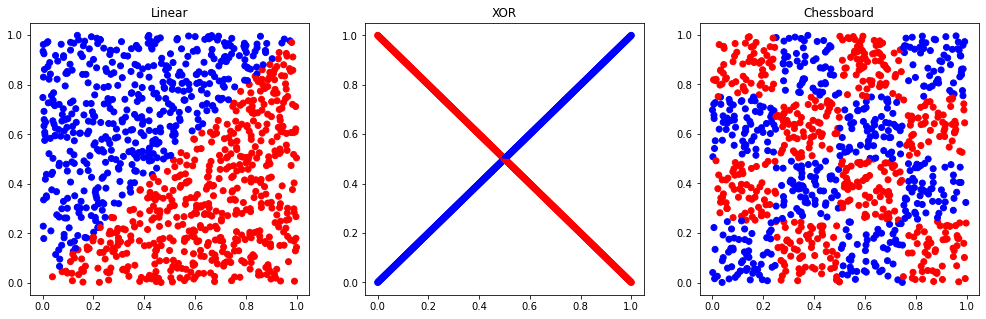

In [2]:
plt.figure(figsize=(17, 5))
for i, name in enumerate(['Linear', 'XOR', 'Chessboard']):
    data, label = GenData.fetch_data(name, 1000)
    plt.subplot(1,3,i+1)
    plt.scatter(data[:, 0], data[:, 1], c=label[:, 0], cmap=plt.cm.bwr)
    plt.title(name)

### Run "Linear"

Epochs 0: accuracy: 50.14%
Epochs 100: accuracy: 88.48%
Epochs 200: accuracy: 95.70%
Epochs 300: accuracy: 97.32%
Epochs 400: accuracy: 97.90%
Epochs 500: accuracy: 98.22%
Epochs 600: accuracy: 98.44%
Epochs 700: accuracy: 98.59%
Epochs 800: accuracy: 98.72%
Epochs 900: accuracy: 98.81%
Epochs 1000: accuracy: 98.89%
Epochs 1100: accuracy: 98.96%
Epochs 1200: accuracy: 99.01%
Epochs 1300: accuracy: 99.06%
Epochs 1400: accuracy: 99.10%
Epochs 1500: accuracy: 99.13%
Epochs 1600: accuracy: 99.16%
Epochs 1700: accuracy: 99.18%
Epochs 1800: accuracy: 99.20%
Epochs 1900: accuracy: 99.22%
Epochs 2000: accuracy: 99.24%
Epochs 2100: accuracy: 99.26%
Epochs 2200: accuracy: 99.27%
Epochs 2300: accuracy: 99.29%
Epochs 2400: accuracy: 99.30%
Epochs 2500: accuracy: 99.30%
Epochs 2600: accuracy: 99.31%
Epochs 2700: accuracy: 99.32%
Epochs 2800: accuracy: 99.33%
Epochs 2900: accuracy: 99.34%
Epochs 3000: accuracy: 99.35%
Epochs 3100: accuracy: 99.36%
Epochs 3200: accuracy: 99.36%
Epochs 3300: accuracy:

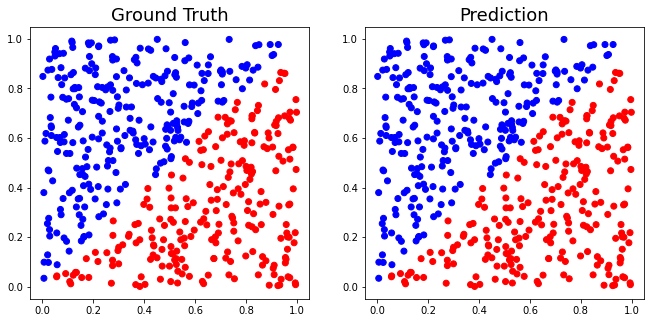

In [3]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Linear", 500)
lr_schedule = {'epoch': [1650,2300,3100], 'decay': 0.5}
net = SimpleNet(3700,lr_Schedule=lr_schedule)
net.train(data, label)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)

### Run "XOR"

Epochs 0: accuracy: 50.00%
Epochs 100: accuracy: 59.31%
Epochs 200: accuracy: 86.45%
Epochs 300: accuracy: 89.69%
Epochs 400: accuracy: 92.93%
Epochs 500: accuracy: 93.09%
Epochs 600: accuracy: 93.06%
Epochs 700: accuracy: 93.09%
Epochs 800: accuracy: 93.69%
Epochs 900: accuracy: 94.09%
Epochs 1000: accuracy: 71.14%
Epochs 1100: accuracy: 74.81%
Epochs 1200: accuracy: 69.57%
Epochs 1300: accuracy: 86.53%
Epochs 1400: accuracy: 86.70%
Epochs 1500: accuracy: 88.58%
Epochs 1600: accuracy: 89.55%
Epochs 1700: accuracy: 94.06%
Epochs 1800: accuracy: 94.66%
Epochs 1900: accuracy: 95.14%
Epochs 2000: accuracy: 95.37%
Epochs 2100: accuracy: 95.29%
Epochs 2200: accuracy: 95.46%
Epochs 2300: accuracy: 95.47%
Epochs 2400: accuracy: 95.69%
Epochs 2500: accuracy: 95.75%
Epochs 2600: accuracy: 95.58%
Epochs 2700: accuracy: 93.78%
Epochs 2800: accuracy: 96.28%
Epochs 2900: accuracy: 96.43%
Epochs 3000: accuracy: 95.99%
Epochs 3100: accuracy: 95.92%
Epochs 3200: accuracy: 94.87%
Epochs 3300: accuracy:

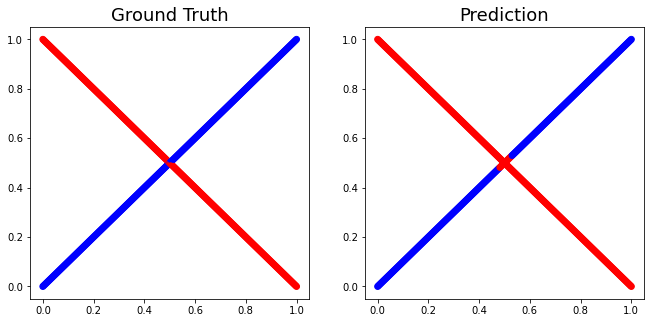

In [62]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("XOR", 500)
lr_schedule = {'epoch': [], 'decay': 0.01}
net = SimpleNet(4500,lr_Schedule=lr_schedule,Optim='RMSprop',learning_rate=1e-3)
net.train(data, label)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)

### Run "Chessboard"

Epochs 0: accuracy: 50.01%
Epochs 100: accuracy: 50.32%
Epochs 200: accuracy: 51.23%
Epochs 300: accuracy: 52.44%
Epochs 400: accuracy: 53.08%
Epochs 500: accuracy: 53.66%
Epochs 600: accuracy: 54.35%
Epochs 700: accuracy: 54.88%
Epochs 800: accuracy: 55.05%
Epochs 900: accuracy: 55.27%
Epochs 1000: accuracy: 55.44%
Epochs 1100: accuracy: 55.50%
Epochs 1200: accuracy: 55.51%
Epochs 1300: accuracy: 55.54%
Epochs 1400: accuracy: 55.49%
Epochs 1500: accuracy: 55.87%
Epochs 1600: accuracy: 56.72%
Epochs 1700: accuracy: 58.73%
Epochs 1800: accuracy: 60.48%
Epochs 1900: accuracy: 60.53%
Epochs 2000: accuracy: 59.88%
Epochs 2100: accuracy: 61.35%
Epochs 2200: accuracy: 61.51%
Epochs 2300: accuracy: 66.17%
Epochs 2400: accuracy: 67.21%
Epochs 2500: accuracy: 68.86%
Epochs 2600: accuracy: 66.98%
Epochs 2700: accuracy: 73.06%
Epochs 2800: accuracy: 69.53%
Epochs 2900: accuracy: 75.19%
Epochs 3000: accuracy: 77.54%
Epochs 3100: accuracy: 78.04%
Epochs 3200: accuracy: 76.85%
Epochs 3300: accuracy:

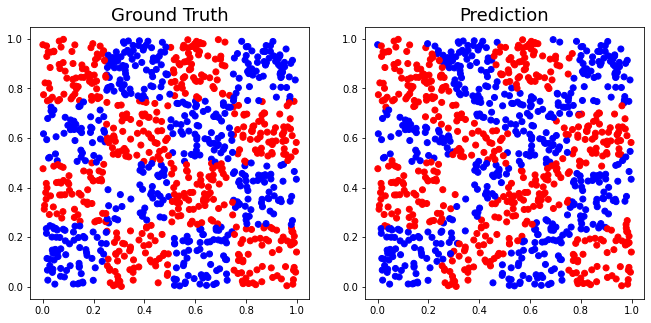

In [88]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)
lr_schedule = {'epoch': [3800,4500], 'decay': 0.1}
net = SimpleNet(5000,lr_Schedule=lr_schedule,Optim='RMSprop',learning_rate=1e-3)
net.train(data, label)

pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)